<p align="center">
<img src="Images/sorbonne_logo.png" alt="Logo" width="300"/>
</p>

# **PANEL DATA ECONOMETRICS - Code File Part 3**

* **Author**: Elia Landini
* **Student ID**: 12310239
* **Course**: EESM2-Financial Economics 
* **Class**: Panel Data Econometrics
* **Supervisor**: Jean-Bernard Chatelain 
* **Reference Paper**: Lofaro, A., & Di Bucchianico, S. (2025). Impact of monetary policy on functional income distribution: A panel vector autoregressive analysis. Economic Modelling, 107227
* **Reference Repository**: https://github.com/EliaLand/PVAR_MonetaryPolicy_FunctionalIncome

### **0) REQUIREMENTS SET-UP**

In [12]:
# Requirements.txt file installation
# !pip install -r requirements.txt

In [31]:
# Libraries import
import warnings
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import levene
from scipy.stats import ks_2samp
from scipy.stats import kstest
from scipy.stats import pearsonr
from scipy.stats import jarque_bera
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.nonparametric.smoothers_lowess import lowess
import plotly.express as px
from IPython.core.display import HTML
from IPython.display import Image
import matplotlib.cm as cm

In [14]:
# Statistical Significance labelling 
def significance_stars(p):
    if p < 0.001:
        return "***"  
    elif p < 0.01:
        return "**"    
    elif p < 0.05:
        return "*"   
    else:
        return ""

In [15]:
# We supress potential warnings with this command
warnings.filterwarnings("ignore")

In [16]:
# Data loading from CodeFile Part 1 for raw data and transformed variables
final_trans_df = pd.read_csv("Data/final_trans_df.csv")
final_trans_df["year"] = pd.to_datetime(final_trans_df["year"])
# (!!!) We need to ensure a 2-level multi-index (or sm estimators won't work, in our case i="country" and t="year")
final_trans_df = final_trans_df.set_index(["country", "year"])
final_trans_df

i      P          W         WR           GDP  \
country   year                                                               
Australia 1970-01-01   7.108333    9.1   6.413648  76.120158  2.835193e+05   
          1971-01-01   7.008333    9.6   6.909308  77.071751  2.946057e+05   
          1972-01-01   5.083333   10.2   7.284607  75.808223  3.023225e+05   
          1973-01-01   6.983333   11.1   8.096658  74.465333  3.147389e+05   
          1974-01-01  13.158333   12.9   9.688749  75.817692  3.189447e+05   
...                         ...    ...        ...        ...           ...   
USA       2015-01-01   0.226667  100.0  65.600000  62.655205  1.820602e+07   
          2016-01-01   0.644167  101.3  66.400000  62.819300  1.850960e+07   
          2017-01-01   1.152500  103.4  68.600000  63.695450  1.892457e+07   
          2018-01-01   2.188333  105.9  70.900000  64.279238  1.948198e+07   
          2019-01-01   2.207500  107.9  73.100000  65.093500  1.992897e+07   

                        LS       PCOM        UN   SHORTUN  LONGUN  ...  \
country   year                                                     ...   
Australia 1970-01-01  59.7   2.113115  1.653364       NaN     NaN  ...   
          1971-01-01  60.4   2.709369  1.907799       NaN     NaN  ...   
          1972-01-01  60.3   2.925285  2.610752       NaN     NaN  ...   
          1973-01-01  60.8   4.174010  2.309362       NaN     NaN  ...   
          1974-01-01  66.9  13.802962  2.670259       NaN     NaN  ...   
...                    ...        ...       ...       ...     ...  ...   
USA       2015-01-01  56.8  66.099106  5.279920  5968.333  2328.0  ...   
          2016-01-01  56.8  56.023884  4.869110  5746.000  2005.0  ...   
          2017-01-01  56.9  69.357989  4.355201  5294.250  1688.0  ...   
          2018-01-01  56.8  89.358138  3.895676  4964.917  1349.0  ...   
          2019-01-01  56.9  78.251714  3.669213  4733.583  1267.0  ...   

                       WR_TWFE      GDP_TWFE   LS_TWFE     PCOM_TWFE  \
country   year                                                         
Australia 1970-01-01  6.652899  6.417193e+05 -1.599571  1.421085e-14   
          1971-01-01  6.815177  6.194218e+05 -1.535286  2.131628e-14   
          1972-01-01  5.360967  5.765079e+05 -1.728143  0.000000e+00   
          1973-01-01  0.878244  5.265239e+05 -0.949571  0.000000e+00   
          1974-01-01  2.643711  5.213183e+05  3.743286  1.421085e-14   
...                        ...           ...       ...           ...   
USA       2015-01-01  9.355536  5.625355e+06  0.469433  0.000000e+00   
          2016-01-01  8.342223  5.882897e+06  0.702767  1.776357e-15   
          2017-01-01  8.851479  6.232285e+06  1.196100 -1.065814e-14   
          2018-01-01  8.792271  6.728788e+06  0.876100 -1.421085e-14   
          2019-01-01  9.679027  7.128463e+06  0.522767 -1.421085e-14   

                       UN_TWFE  SHORTUN_TWFE  LONGUN_TWFE       LF_TWFE  \
country   year                                                            
Australia 1970-01-01  0.083200           NaN          NaN   3746.924114   
          1971-01-01 -0.010331           NaN          NaN   3673.600806   
          1972-01-01  0.306079           NaN          NaN   3516.775114   
          1973-01-01  0.280121           NaN          NaN   3252.168575   
          1974-01-01  0.703663           NaN          NaN   2769.733122   
...                        ...           ...          ...           ...   
USA       2015-01-01 -2.158072   -366.715087   510.316135  23419.420004   
          2016-01-01 -2.012960   -557.504449   282.317657  25183.856004   
          2017-01-01 -1.792373   -943.479016    65.509990  26116.245337   
          2018-01-01 -1.493159  -1224.491436  -171.593610  27580.072337   
          2019-01-01 -1.360396  -1436.126789  -192.683076  28785.793337   

                      REER_TWFE   SH_TWFE  
country   year                             
Australia 1970-01-01   2.873095 -2.544304  
       

### **3) PART 3 - OPEN SECTION**

##### <span style="color: red"> **3.25) Do whatever seem interesting to you in terms of original estimations (not already done by the replication of the original authors) with this database, present the table(s) in this file with comments, not only in the html output with code and output.** </span>

In [22]:
# Panel Local Projections (LP) IRFs
# We build a "monetary policy shock" as a policy-rule residual
# (!!!) We want to simulate an “unexpected tightening” measure. Without a narrative/market surprise series, we take the residual from a policy rule that explains the systematic part of the policy rate. Residual = “innovation/shock”.
# (!!!) We also include: country fixed effects (entity_effects) to absorb time-invariant country differences, year fixed effects (time_effects) to absorb global shocks common to all countries
# We cluster SEs by country because macro panels have within-country serial dependence.

df = final_trans_df.copy()
# Controls
rhs = ["P", "GDP"]

# ///////////
# Policy Rule
# ///////////
# (!!!) i_it = a + b*P_it + c*GDP_it + FE_i + FE_t + u_it
rule = PanelOLS(
    df["i"],
    sm.add_constant(df[rhs]),
# Country FE
    entity_effects=True,  
# Year FE
    time_effects=True      
).fit(cov_type="clustered", cluster_entity=True)
print(rule.summary)

# (!!!) So here the residuals are the "monetary policy shocks" (unexpected component)
df["mp_shock"] = rule.resids
mon_pol_df = df.copy() 

                          PanelOLS Estimation Summary                           
Dep. Variable:                      i   R-squared:                        0.1251
Estimator:                   PanelOLS   R-squared (Between):              0.4697
No. Observations:                 750   R-squared (Within):               0.5104
Date:                Sun, Dec 28 2025   R-squared (Overall):              0.5075
Time:                        10:33:41   Log-likelihood                   -1525.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      48.890
Entities:                          15   P-value                           0.0000
Avg Obs:                       50.000   Distribution:                   F(2,684)
Min Obs:                       50.000                                           
Max Obs:                       50.000   F-statistic (robust):             9.4946
                            

In [32]:
# Local Projections for WR (horizon from 0 to 4)
# (!!!) We deploy local projections, instead of imposing VAR dynamics, as LP estimates each horizon directly.
# (!!!) WR_i,t+h ​= ah​ + bh​shock_i,t ​+ controls + FE_i ​+ FE_t ​+ u_i,t+h​
# (!!!) GDP and P as controls to avoid attributing systematic macro movements
df = mon_pol_df.copy()

# //////
# Set-Up
# //////
# We define the horizons in a range (0,4) for short-run and long-run responses
H = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lp_wr_rows = []
# Loop over each potential horizon in the range H
for horizon in H:
# Lead of the outcome - WR_t+h
# (!!!) We shift within each country to preserve panel structure
    df[f"WR_lead{horizon}"] = df.groupby(level=0)["WR"].shift(-horizon)
# Regressors
# (!!!) We take mp_shock from the previously computed residuals and we plug them back in the LP model
    X_cols = ["mp_shock", "GDP", "P"]

# //////////////////////////////////////
# LP Regression with FE and Clustered SE 
# //////////////////////////////////////
    res = PanelOLS(
        df[f"WR_lead{horizon}"],
        sm.add_constant(df[X_cols]),
# FE (entity + time)
        entity_effects=True,
        time_effects=True
# Clustered SE
    ).fit(cov_type="clustered", cluster_entity=True)

# /////////////////////
# IRF coefficient (b_h)
# ///////////////////// 
    lp_wr_rows.append({
        "Horizon": horizon,
        "Beta_shock (WR)": res.params["mp_shock"],
        "Standard Error": res.std_errors["mp_shock"],
        "p-value": res.pvalues["mp_shock"],
        "N-obs": int(res.nobs)
    })

lp_wr = pd.DataFrame(lp_wr_rows)
lp_wr

,Horizon,Beta_shock (WR),Standard Error,p-value,N-obs
0,0,-2.160037,1.363993,0.113752,740
1,1,-2.393810,1.367005,0.080387,726
2,2,-2.425082,1.318415,0.066316,712
3,3,-2.347507,1.263675,0.063678,698
4,4,-2.144860,1.125849,0.057228,684
5,5,-1.985700,1.006855,0.049042,670
6,6,-1.808681,0.857490,0.035338,656
7,7,-1.571341,0.715341,0.028440,642
8,8,-1.387678,0.601238,0.021355,628
9,9,-1.198006,0.517400,0.020952,614


In [33]:
# Local Projections for LS (horizon from 0 to 4)
# (!!!) Same logic as for WR
# (!!!) LS_i,t+h ​= ah​ + bh​shock_i,t ​+ controls + FE_i ​+ FE_t ​+ u_i,t+h​

df = mon_pol_df.copy()

# //////
# Set-Up
# //////
# We define the horizons in a range (0,4) for short-run responses
H = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lp_ls_rows = []
# Loop over each potential horizon in the range H
for horizon in H:
# Lead of the outcome - LS_t+h
# (!!!) We shift within each country to preserve panel structure
    df[f"LS_lead{horizon}"] = df.groupby(level=0)["LS"].shift(-horizon)
# Regressors
# (!!!) We take mp_shock from the previously computed residuals and we plug them back in the LP model
    X_cols = ["mp_shock", "GDP", "P"]

# //////////////////////////////////////
# LP Regression with FE and Clustered SE 
# //////////////////////////////////////
    res = PanelOLS(
        df[f"LS_lead{horizon}"],
        sm.add_constant(df[X_cols]),
# FE (entity + time)
        entity_effects=True,
        time_effects=True
# Clustered SE
    ).fit(cov_type="clustered", cluster_entity=True)

# /////////////////////
# IRF coefficient (b_h)
# ///////////////////// 
    lp_ls_rows.append({
        "Horizon": horizon,
        "Beta_shock (LS)": res.params["mp_shock"],
        "Standard Error": res.std_errors["mp_shock"],
        "p-value": res.pvalues["mp_shock"],
        "N-obs": int(res.nobs)
    })

lp_ls = pd.DataFrame(lp_ls_rows)
lp_ls

,Horizon,Beta_shock (LS),Standard Error,p-value,N-obs
0,0,-0.075873,0.209924,0.717890,740
1,1,-0.115428,0.242103,0.633681,726
2,2,-0.178161,0.230498,0.439840,712
3,3,-0.199030,0.200681,0.321687,698
4,4,-0.213004,0.179664,0.236245,684
5,5,-0.200595,0.162900,0.218649,670
6,6,-0.150047,0.127061,0.238111,656
7,7,-0.086626,0.094790,0.361164,642
8,8,-0.045667,0.074950,0.542569,628
9,9,0.007433,0.073230,0.919192,614


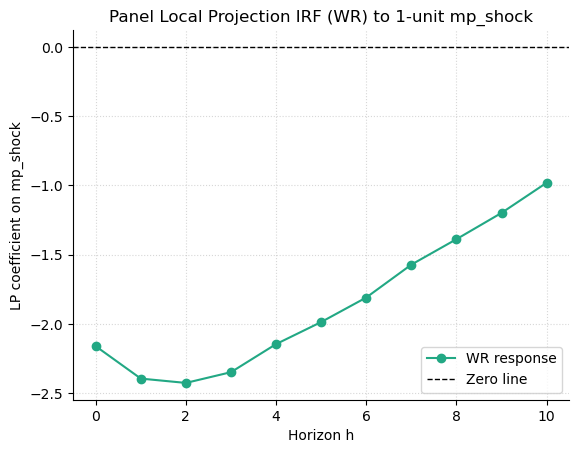

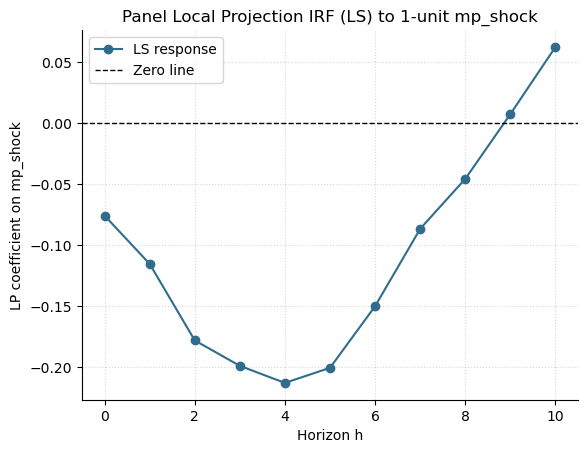

In [37]:
# IRF-curves Plotting
# (!!!) Code from Part 2 
viridis_color = cm.viridis(0.6)

# //////////////////////
# Real Compensation (WR)
# //////////////////////
plt.figure()
plt.plot(lp_wr["Horizon"], lp_wr["Beta_shock (WR)"], marker="o", color=viridis_color, label="WR response")
plt.axhline(0, color="black", linestyle="--", linewidth=1, label="Zero line")
plt.grid(True, linestyle=":", alpha=0.5)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xlabel("Horizon h")
plt.ylabel("LP coefficient on mp_shock")
plt.title("Panel Local Projection IRF (WR) to 1-unit mp_shock")
plt.legend()
plt.show()

# /////////////////
# Labour Share (LS)
# /////////////////
plt.figure()
plt.plot(lp_ls["Horizon"], lp_ls["Beta_shock (LS)"], marker="o", color=cm.viridis(0.35), label="LS response")
plt.axhline(0, color="black", linestyle="--", linewidth=1, label="Zero line")
plt.grid(True, linestyle=":", alpha=0.5)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xlabel("Horizon h")
plt.ylabel("LP coefficient on mp_shock")
plt.title("Panel Local Projection IRF (LS) to 1-unit mp_shock")
plt.legend()
plt.show()

In [38]:
# WR - Diagnostic Test - Placebo/pre-trend check (shock lead)
# (!!!) If the shock is truly unanticipated, a future shock should not predict today’s outcomes.
# (!!!) So when we regress WR_t and LS_t on mp_shock_t+1, we want the coefficient to be close to zero.
df = mon_pol_df.copy()

# Future shock (t+1)
df["shock_lead1"] = df.groupby(level=0)["mp_shock"].shift(-1)
X_cols = ["shock_lead1", "GDP", "P"]

# Place test - WR
placebo_wr = PanelOLS(
    df["WR"],
    sm.add_constant(df[X_cols]),
    entity_effects=True,
    time_effects=True
).fit(cov_type="clustered", cluster_entity=True)
print(placebo_wr.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     WR   R-squared:                        0.3164
Estimator:                   PanelOLS   R-squared (Between):              0.0185
No. Observations:                 725   R-squared (Within):              -4.5416
Date:                Sun, Dec 28 2025   R-squared (Overall):             -3.5547
Time:                        11:04:28   Log-likelihood                   -2920.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      101.68
Entities:                          15   P-value                           0.0000
Avg Obs:                       48.333   Distribution:                   F(3,659)
Min Obs:                       39.000                                           
Max Obs:                       49.000   F-statistic (robust):             3.8816
                            

In [39]:
# LS - Diagnostic Test - Placebo/pre-trend check (shock lead)
# (!!!) Same thing for LS
df = mon_pol_df.copy()

# Future shock (t+1)
df["shock_lead1"] = df.groupby(level=0)["mp_shock"].shift(-1)
X_cols = ["shock_lead1", "GDP", "P"]

# Place test - LS
placebo_wr = PanelOLS(
    df["LS"],
    sm.add_constant(df[X_cols]),
    entity_effects=True,
    time_effects=True
).fit(cov_type="clustered", cluster_entity=True)
print(placebo_wr.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     LS   R-squared:                        0.0413
Estimator:                   PanelOLS   R-squared (Between):             -0.0071
No. Observations:                 725   R-squared (Within):               0.2912
Date:                Sun, Dec 28 2025   R-squared (Overall):              0.1760
Time:                        11:05:22   Log-likelihood                   -1693.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      9.4627
Entities:                          15   P-value                           0.0000
Avg Obs:                       48.333   Distribution:                   F(3,659)
Min Obs:                       39.000                                           
Max Obs:                       49.000   F-statistic (robust):             2.9127
                            